In [ ]:
import numpy as np
import pandas as pd
import scipy
from sklearn.model_selection import train_test_split
import os
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet') 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
!pip install autocorrect
from autocorrect import Speller
!pip install ipython-autotime
%load_ext autotime

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
     |████████████████████████████████| 622 kB 5.4 MB/s 
  Created wheel for autocorrect: filename=autocorrect-2.5.0-py3-none-any.whl size=621851 sha256=2a6a5f45a9c5b00c695684cbd8a1073aa0f85e01f40016cd03481c1913e7b7bc
  Stored in directory: /root/.cache/pip/wheels/3d/8e/bd/f6fd900a056a031bf710a00bca338d86f43b83f0c25ab5242f
Successfully built autocorrect
time: 200 µs (started: 2021-10-12 03:00:45 +00:00)


# Pre-processing criterion

* Remove header or tail of article if needed (**Ex**. *WASHINGTON (Reuters) -* , **Ex**. *For entire article: Chicago Tribune*) 

> **Kaggle1 True** specific header & tail
> * **WASHINGTON (Reuters) -** ...
> * ... **-- Source link: (bit.ly/2jBh4LU)**

> **Kaggle1 Fake** specific header & tail
> * **The following statements were posted to the verified Twitter accounts** ...
> * ... **For entire article: Chicago Tribune**
> * ... **Featured image via David McNew/Stringer/Getty Images**
> * ... **Photo by Christopher Furlong/Getty Images**

> **Kaggle3** specific header & tail
> * **LONDON (Reuters) -** ...
> * **Image copyright Getty Images** ...
> * ... **-- Source link: (bit.ly/2jBh4LU)**


* Remove Twitter ID (**Ex**. *@Gonzalez*), probabily one or two word infront of it (name) and 3 words after it (date) (**Ex**. *John McCain (@SenJohnMcCain) December 4, 2017*)
* Remove url (**Ex**. (*bit.ly/2jBh4LU*), (Graphic: tmsnrt.rs/@Bgq29K), (*pic.twitter.com/4FPAe2KypA*), https//t.co/zcbyc4wp5b), 
* Remove words in square bracket (**Ex**. *\[nL1N1FIOK0]*), hashtags (**Ex**. *\#NOBAnNoWall*)
* Replace none alphabetic characters (i.e. characters other than A\~Z, a\~z) by space
* Transform letters into lowercase
* Remove the stopwords (frequently used but meaningless words, **Ex**. *me, my, you, do, a, the*)
* Remove one letter words (possibly generated by error)
* Transform words into the base form (`nltk.wordnet.WordNetLemmatizer()`)
* Spell correction (`autocorrect.Speller`)
* Exclude pre-processed article with less than 5 words



In [ ]:
lemma = nltk.wordnet.WordNetLemmatizer()
spell = Speller(lang='en')

def preprocess(text):
  text=str(text)
  
  # Header exclusion
  header = re.search("\(Reuters\) -|Image copyright Getty Images|The following statements[ ]{0,1}[^ ]*[ ]{0,1}were posted to the verified Twitter accounts", text)
  if header: text = text[header.end():]

  # Tail exclusion
  tail = re.search("For entire article:|Featured image via|Photo by", text)
  if tail: text = text[:tail.start()]

  # Remove Twitter ID
  text = re.sub("\@[^ ]*" ,"", text)

  # Remove url
  text = re.sub("bit.[^ ]*|Graphic: [^ ]*|pic.twitter.[^ ]*|https[^ ]*", "", text)

  # Remove words in square bracket and hashtags
  text = re.sub("\[[^ ]*\]|\#[^ ]*", "", text)

  # Replace none alphabetic characters by space
  text = re.sub("[^A-Za-z]", " ", text)

  # Transform letters into lowercase
  text = text.lower()

  # Remove the stopwords and one-letter word
  pattern = re.compile(r'\b(' + r'|'.join(stopwords.words("english") + list(string.ascii_lowercase)) + r')\b\s*')
  text = pattern.sub('', text)

  # A string to a word list for future pre-processing
  tokenized_text = word_tokenize(text)

  # Transform words into the base form and Spell correction
  tokenized_text_final = [spell(lemma.lemmatize(word)) for word in tokenized_text]

  # Exclude pre-process article with less than 5 words
  if len(tokenized_text_final) < 5: return ""
  else: return " ".join(tokenized_text_final)


### Example ###
teststr = "WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress. For entire article: Chicago Tribune"
print(teststr + "\n" + preprocess(teststr) + "\n")

teststr = "Image copyright Getty Images. The head of a conservative Republican faction in the U.S. Congress. Photo by Christopher Furlong/Getty Images"
print(teststr + "\n" + preprocess(teststr) + "\n")

teststr = "The head @Gonzalez of a conservative Republican faction in the U.S. Congress. Photo by Christopher Furlong/Getty Images"
print(teststr + "\n" + preprocess(teststr) + "\n")

teststr = "The head of a conservative Republican faction in the U.S. Congress. (bit.ly/2jBh4LU), (Graphic: tmsnrt.rs/@Bgq29K), (pic.twitter.com/4FPAe2KypA), https//t.co/zcbyc4wp5b)"
print(teststr + "\n" + preprocess(teststr) + "\n")

teststr = "Removv words in square bracket (Ex. [nL1N1FIOK0]), hashtags (Ex. #NOBAnNoWall)"
print(teststr + "\n" + preprocess(teststr) + "\n")

teststr = "Removv words in square bracket"
print(teststr + "\n" + preprocess(teststr) + "\n")


WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress. For entire article: Chicago Tribune
head conservative republican faction congress

Image copyright Getty Images. The head of a conservative Republican faction in the U.S. Congress. Photo by Christopher Furlong/Getty Images
head conservative republican faction congress

The head @Gonzalez of a conservative Republican faction in the U.S. Congress. Photo by Christopher Furlong/Getty Images
head conservative republican faction congress

The head of a conservative Republican faction in the U.S. Congress. (bit.ly/2jBh4LU), (Graphic: tmsnrt.rs/@Bgq29K), (pic.twitter.com/4FPAe2KypA), https//t.co/zcbyc4wp5b)
head conservative republican faction congress

Removv words in square bracket (Ex. [nL1N1FIOK0]), hashtags (Ex. #NOBAnNoWall)
remove word square bracket ex hashtag ex

Removv words in square bracket


time: 142 ms (started: 2021-10-09 22:58:08 +00:00)


# Kaggle 1

https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset

In [ ]:
Kaggle1_fake = pd.read_csv('Kaggle1_Fake.csv')
Kaggle1_true = pd.read_csv('Kaggle1_True.csv')

In [ ]:
Kaggle1_fake_df = Kaggle1_fake.assign(label = 0)
Kaggle1_fake_df = Kaggle1_fake_df[['text', 'label']]
Kaggle1_fake_df = Kaggle1_fake_df.assign(text = lambda dataframe: dataframe['text'].map(preprocess))
Kaggle1_fake_df

In [ ]:
Kaggle1_true_df = Kaggle1_true.assign(label = 1)
Kaggle1_true_df = Kaggle1_true_df[['text', 'label']]
Kaggle1_true_df = Kaggle1_true_df.assign(text = lambda dataframe: dataframe['text'].map(preprocess))
Kaggle1_true_df

In [ ]:
# Check with just 10 articles

Kaggle1_true_df = Kaggle1_true.assign(label = 1)
Kaggle1_true_df = Kaggle1_true_df[['text', 'label']]
Kaggle1_true_df1 = Kaggle1_true_df.iloc[0:10,]
Kaggle1_true_df1 = Kaggle1_true_df1.assign(text = lambda dataframe: dataframe['text'].map(preprocess))
Kaggle1_true_df1

,text,label
0,head conservative republican faction congress ...,1
1,transgender people allowed first time enlist m...,1
2,special counsel investigation link russia pres...,1
3,trump campaign adviser george papadopoulos tol...,1
4,president donald trump called postal service f...,1
5,white house said friday set kick talk next wee...,1
6,president donald trump said thursday belief fa...,1
7,president donald trump opinion expressed reute...,1
8,president donald trump opinion expressed reute...,1
9,alabama secretary state john merriam said cert...,1


time: 4.48 s (started: 2021-10-09 22:58:14 +00:00)


In [ ]:
print("Raw: " + Kaggle1_true_df.iloc[8,0] + "\n" + "Processed: " + Kaggle1_true_df1.iloc[8,0])

Raw: The following statements were posted to the verified Twitter accounts of U.S. President Donald Trump, @realDonaldTrump and @POTUS.  The opinions expressed are his own. Reuters has not edited the statements or confirmed their accuracy.  @realDonaldTrump : - Together, we are MAKING AMERICA GREAT AGAIN! bit.ly/2lnpKaq [1814 EST] - In the East, it could be the COLDEST New Year’s Eve on record. Perhaps we could use a little bit of that good old Global Warming that our Country, but not other countries, was going to pay TRILLIONS OF DOLLARS to protect against. Bundle up! [1901 EST] -- Source link: (bit.ly/2jBh4LU) (bit.ly/2jpEXYR) 
Processed: president donald trump opinion expressed reuters edited statement confirmed accuracy together making america great est east could coldest new year eve record perhaps could use little good old global warming country country going pay trillion dollar protect bundle est source link


# Kaggle 2

https://www.kaggle.com/ksaivenketpatro/fake-news-detection-dataset

In [ ]:
Kaggle2 = pd.read_csv('Kaggle2.csv')
Kaggle2

,Statement,Label
0,Says the Annies List political group supports ...,False
1,When did the decline of coal start? It started...,True
2,"Hillary Clinton agrees with John McCain ""by vo...",True
3,Health care reform legislation is likely to ma...,False
4,The economic turnaround started at the end of ...,True
...,...,...
10235,There are a larger number of shark attacks in ...,True
10236,Democrats have now become the party of the [At...,True
10237,Says an alternative to Social Security that op...,True
10238,On lifting the U.S. Cuban embargo and allowing...,False


In [ ]:
Kaggle2_df = Kaggle2.rename({'Statement': 'text', 'Label': 'label'}, axis=1)
Kaggle2_df

,text,label
0,Says the Annies List political group supports ...,False
1,When did the decline of coal start? It started...,True
2,"Hillary Clinton agrees with John McCain ""by vo...",True
3,Health care reform legislation is likely to ma...,False
4,The economic turnaround started at the end of ...,True
...,...,...
10235,There are a larger number of shark attacks in ...,True
10236,Democrats have now become the party of the [At...,True
10237,Says an alternative to Social Security that op...,True
10238,On lifting the U.S. Cuban embargo and allowing...,False


In [ ]:
def truefalse_to_01(label):
  if label is True:
    return 1
  if label is False:
    return 0

Kaggle2_df = Kaggle2.rename({'Statement': 'text', 'Label': 'label'}, axis=1)
Kaggle2_df = Kaggle2_df.assign(label = lambda dataframe: dataframe['label'].map(truefalse_to_01))
Kaggle2_df

,text,label
0,Says the Annies List political group supports ...,0
1,When did the decline of coal start? It started...,1
2,"Hillary Clinton agrees with John McCain ""by vo...",1
3,Health care reform legislation is likely to ma...,0
4,The economic turnaround started at the end of ...,1
...,...,...
10235,There are a larger number of shark attacks in ...,1
10236,Democrats have now become the party of the [At...,1
10237,Says an alternative to Social Security that op...,1
10238,On lifting the U.S. Cuban embargo and allowing...,0


In [ ]:
Kaggle2_df.to_csv('Kaggle2.csv', sep='\t', index = False)

# Kaggle 3

https://www.kaggle.com/jruvika/fake-news-detection?select=data.csv

In [ ]:
Kaggle3 = pd.read_csv('Kaggle3.csv')
Kaggle3

,URLs,Headline,Body,Label
0,http://www.bbc.com/news/world-us-canada-414191...,Four ways Bob Corker skewered Donald Trump,Image copyright Getty Images\nOn Sunday mornin...,1
1,https://www.reuters.com/article/us-filmfestiva...,Linklater's war veteran comedy speaks to moder...,"LONDON (Reuters) - “Last Flag Flying”, a comed...",1
2,https://www.nytimes.com/2017/10/09/us/politics...,Trump’s Fight With Corker Jeopardizes His Legi...,The feud broke into public view last week when...,1
3,https://www.reuters.com/article/us-mexico-oil-...,Egypt's Cheiron wins tie-up with Pemex for Mex...,MEXICO CITY (Reuters) - Egypt’s Cheiron Holdin...,1
4,http://www.cnn.com/videos/cnnmoney/2017/10/08/...,Jason Aldean opens 'SNL' with Vegas tribute,"Country singer Jason Aldean, who was performin...",1
...,...,...,...,...
4004,http://beforeitsnews.com/sports/2017/09/trends...,Trends to Watch,Trends to Watch\n% of readers think this story...,0
4005,http://beforeitsnews.com/u-s-politics/2017/10/...,Trump Jr. Is Soon To Give A 30-Minute Speech F...,Trump Jr. Is Soon To Give A 30-Minute Speech F...,0
4006,https://www.activistpost.com/2017/09/ron-paul-...,"Ron Paul on Trump, Anarchism & the AltRight",NaN,0
4007,https://www.reuters.com/article/us-china-pharm...,China to accept overseas trial data in bid to ...,SHANGHAI (Reuters) - China said it plans to ac...,1


In [ ]:
Kaggle3_df = Kaggle3[['Body', 'Label']]
Kaggle3_df = Kaggle3_df.rename({'Body': 'text', 'Label': 'label'}, axis=1)
Kaggle3_df = Kaggle3_df.assign(text = lambda dataframe: dataframe['text'].map(deleteheader))

Kaggle3_df

,text,label
0,Image copyright Getty Images\nOn Sunday mornin...,1
1,"“Last Flag Flying”, a comedy-drama about Vietn...",1
2,The feud broke into public view last week when...,1
3,Egypt’s Cheiron Holdings Limited won the right...,1
4,"Country singer Jason Aldean, who was performin...",1
...,...,...
4004,Trends to Watch\n% of readers think this story...,0
4005,Trump Jr. Is Soon To Give A 30-Minute Speech F...,0
4006,nan,0
4007,China said it plans to accept data from overse...,1


In [ ]:
Kaggle3_df.to_csv('Kaggle3.csv', sep='\t', index = False)

# LIAR 

In [ ]:
uri_train  = 'https://raw.githubusercontent.com/thiagorainmaker77/liar_dataset/master/train.tsv'
uri_valid  = 'https://raw.githubusercontent.com/thiagorainmaker77/liar_dataset/master/valid.tsv'
uri_test  = 'https://raw.githubusercontent.com/thiagorainmaker77/liar_dataset/master/test.tsv'

    
df_train = pd.read_table(uri_train,
                             names = ['id',	'label'	,'statement',	'subject',	'speaker', 	'job', 	'state',	'party',	'barely_true_c',	'false_c',	'half_true_c',	'mostly_true_c',	'pants_on_fire_c',	'venue'])

    
df_valid = pd.read_table(uri_valid,
                             names =['id',	'label'	,'statement',	'subject',	'speaker', 	'job', 	'state',	'party',	'barely_true_c',	'false_c',	'half_true_c',	'mostly_true_c',	'pants_on_fire_c',	'venue'])


df_test = pd.read_csv(uri_test, sep='\t', 
                            names =['id',	'label'	,'statement',	'subject',	'speaker', 	'job', 	'state',	'party',	'barely_true_c',	'false_c',	'half_true_c',	'mostly_true_c',	'pants_on_fire_c',	'venue']) 


df = pd.concat([df_train, df_valid, df_test])

In [ ]:
def switchfunc(label):
  if label in ["true", "mostly-true"]:
    return 1
  if label in ["pants-fire", "false"]:
    return 0
  return -1

In [ ]:
df_LIAR = df[['statement', 'label']]
df_LIAR = df_LIAR.assign(label = lambda dataframe: dataframe['label'].map(switchfunc))
df_LIAR = df_LIAR[df_LIAR['label'] != -1]
df_LIAR = df_LIAR.rename({'statement': 'text'}, axis=1)
df_LIAR

,text,label
0,Says the Annies List political group supports ...,0
2,"Hillary Clinton agrees with John McCain ""by vo...",1
3,Health care reform legislation is likely to ma...,0
5,The Chicago Bears have had more starting quart...,1
9,Says GOP primary opponents Glenn Grothman and ...,1
...,...,...
1256,Says Chris Christies plan to kick-start our ec...,0
1257,Obama used $20 million in federal money to emm...,0
1260,I think its seven or eight of the California s...,0
1261,Sen. Bob Menendez voted to enact a new tax on ...,0


# ==================== After pre-processing ===================

Pre-processing using `preprocess` function is done by submitting job on computing cluster (Longleaf).


In [ ]:
# Combining pre-processed data frame to make a entire BOW matrix

import pickle

with open('Kaggle1_fake_processed.p', 'rb') as Kaggle1_fake: 
    Kaggle1_fake_processed = pickle.load(Kaggle1_fake)

with open('Kaggle1_true_processed.p', 'rb') as Kaggle1_true: 
    Kaggle1_true_processed = pickle.load(Kaggle1_true)

with open('Kaggle2_processed.p', 'rb') as Kaggle2: 
    Kaggle2_processed = pickle.load(Kaggle2)

with open('Kaggle3_processed.p', 'rb') as Kaggle3: 
    Kaggle3_processed = pickle.load(Kaggle3)

with open('LIAR_processed.p', 'rb') as liar: 
    LIAR_processed = pickle.load(liar)

import pandas as pd
combined_df = pd.concat([Kaggle1_fake_processed, Kaggle1_true_processed, Kaggle2_processed, Kaggle3_processed, LIAR_processed], ignore_index=True)

with open('combined_df.p', 'wb') as file:
    pickle.dump(combined_df, file)

combined_df

In [ ]:
# Combined data frame to BOW matrix 

'''
from sklearn.feature_extraction.text import CountVectorizer
import pickle
vectorizer = CountVectorizer()
Y = vectorizer.fit_transform(combined_df.iloc[:,0]).toarray()
print(Y)
print(Y.shape)
print(vectorizer.vocabulary_)

# dense to sparse
from numpy import array
from scipy.sparse import csr_matrix
# convert to sparse matrix (CSR method)
S = csr_matrix(Y)
print(S)

with open('combined_BOW.p', 'wb') as file:
    pickle.dump(S, file)
    pickle.dump(vectorizer.vocabulary_, file)

'''

In [ ]:
import pickle

with open('combined_BOW.p', 'rb') as combined: 
    combined_BOW_matrix = pickle.load(combined)
    combined_vocab = pickle.load(combined)

print(combined_BOW_matrix)
print(combined_vocab)

  (0, 347)	1
  (0, 1199)	1
  (0, 1230)	1
  (0, 1442)	1
  (0, 1527)	1
  (0, 1583)	1
  (0, 1662)	3
  (0, 1668)	2
  (0, 1929)	1
  (0, 1998)	1
  (0, 2216)	1
  (0, 3546)	1
  (0, 4236)	1
  (0, 4923)	1
  (0, 5864)	1
  (0, 6821)	1
  (0, 7777)	2
  (0, 8508)	1
  (0, 8660)	1
  (0, 9695)	1
  (0, 10004)	1
  (0, 10377)	2
  (0, 11177)	1
  (0, 11251)	1
  (0, 11536)	13
  :	:
  (67205, 48134)	1
  (67205, 50637)	1
  (67206, 5298)	1
  (67206, 14801)	1
  (67206, 21475)	1
  (67206, 29709)	1
  (67206, 32418)	1
  (67206, 41757)	1
  (67206, 42908)	1
  (67206, 47481)	1
  (67206, 51983)	1
  (67207, 2610)	1
  (67207, 4454)	1
  (67207, 11022)	1
  (67207, 14065)	2
  (67207, 18069)	1
  (67207, 19117)	1
  (67207, 19302)	1
  (67207, 21104)	1
  (67207, 22702)	3
  (67207, 27792)	1
  (67207, 42104)	1
  (67207, 45573)	1
  (67207, 47281)	1
  (67207, 47481)	1
{'donald': 13429, 'trump': 49460, 'wish': 53202, 'american': 1668, 'happy': 20355, 'new': 32418, 'year': 53831, 'leave': 26723, 'instead': 23277, 'give': 18893, 'shout

In [ ]:
# words list (column of BOW matrix)

worddict = dict(sorted(combined_vocab.items(), key=lambda item: item[1]))
wordlist = list(worddict.keys())
print(wordlist)
print(len(wordlist))

['aa', 'aaa', 'aaaa', 'aaaaaa', 'aaaaaaaand', 'aaaaackkk', 'aaaahhhh', 'aaaarrgh', 'aab', 'aabfsv', 'aac', 'aachen', 'aad', 'aadhaar', 'aaf', 'aaffaa', 'aai', 'aaliyah', 'aamrrd', 'aan', 'aap', 'aar', 'aardvark', 'aaron', 'aaronson', 'aarushi', 'aas', 'aayrvh', 'ab', 'aba', 'abaaoud', 'abaaouddinajpur', 'ababacar', 'abac', 'abandon', 'abandoned', 'abandoning', 'abandonment', 'abanotubani', 'abatembo', 'abattoir', 'abayomi', 'abb', 'abballakabul', 'abbas', 'abbattoir', 'abbess', 'abbeville', 'abbey', 'abbot', 'abbotabad', 'abbott', 'abbottabad', 'abbottnoteworthy', 'abbr', 'abbrev', 'abbreviated', 'abbreviation', 'abbynailed', 'abc', 'abcdemocratic', 'abci', 'abcknox', 'abclocal', 'abcnews', 'abcwilders', 'abd', 'abddhal', 'abdelal', 'abdelaoui', 'abdelaty', 'abdelazim', 'abdelaziz', 'abdelbaki', 'abdelbari', 'abdeldahim', 'abdelhadi', 'abdelhady', 'abdelhakim', 'abdelhamid', 'abdelkader', 'abdelkafi', 'abdelkerim', 'abdelkhalik', 'abdelmageed', 'abdelmoneim', 'abdelrahim', 'abdelslam',

## Word frequency analysis 

In [ ]:
# Column sum = frequency of word appearance over articles

BOW_mat_colsum = np.sum(combined_BOW_matrix, axis = 0)
print(BOW_mat_colsum.shape)
BOW_mat_colsum = np.ravel(np.asarray(BOW_mat_colsum))
BOW_mat_colsum

(1, 54463)


array([ 43, 170,   1, ...,   1,   1,   1], dtype=int64)

time: 43.2 ms (started: 2021-10-12 03:00:51 +00:00)


In [ ]:
# Words appeared only one time
np.asarray(wordlist)[np.where(BOW_mat_colsum == 1)]

array(['aaaa', 'aaaaaaaand', 'aaaaackkk', ..., 'zztaine', 'zzzzzzzz',
       'zzzzzzzzzzzzz'], dtype='<U130')

time: 31.1 ms (started: 2021-10-12 01:10:35 +00:00)


In [ ]:
# Words appeared only 2 times
np.asarray(wordlist)[np.where(BOW_mat_colsum == 2)]

array(['aaffaa', 'aar', 'aayrvh', ..., 'zvoncheck', 'zwickau', 'zygote'],
      dtype='<U130')

time: 33.7 ms (started: 2021-10-12 01:12:23 +00:00)


In [ ]:
# Words appeared only 3 times
np.asarray(wordlist)[np.where(BOW_mat_colsum == 3)]

array(['abac', 'abddhal', 'abdelbaki', ..., 'zuppiger', 'zurawik',
       'zwillich'], dtype='<U130')

time: 27.8 ms (started: 2021-10-12 01:12:34 +00:00)


In [ ]:
# Words appeared only 4 times
np.asarray(wordlist)[np.where(BOW_mat_colsum == 4)]

array(['abbotabad', 'abci', 'abdelmageed', ..., 'zorzoli', 'zubaidi',
       'zv'], dtype='<U130')

time: 31.5 ms (started: 2021-10-12 01:12:42 +00:00)


In [ ]:
# Number of words that appeared 0, 1, 2, ..., 10 times
np.histogram(BOW_mat_colsum, bins=range(np.max(BOW_mat_colsum)+1))[0][:10]

array([    0, 12141,  7656,  2887,  2321,  1493,  1348,  1012,   939,
         756])

time: 92.9 ms (started: 2021-10-12 00:56:47 +00:00)


(0.6248665502294368, 12150.0)

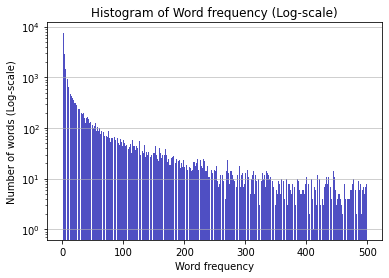

time: 2.1 s (started: 2021-10-12 00:54:56 +00:00)


In [ ]:
import matplotlib.pyplot as plt

# An "interface" to matplotlib.axes.Axes.hist() method
n, bins, patches = plt.hist(x=BOW_mat_colsum, bins=range(500), color='#0504aa',
                            alpha=0.7, rwidth=0.85, log = True)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Word frequency')
plt.ylabel('Number of words (Log-scale)')
plt.title('Histogram of Word frequency (Log-scale)')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

## Number of articles that contain a word

In [ ]:
# contain matrix, (i,j) element = 1 if the i-th article contains j-th word

contain_matrix = combined_BOW_matrix.copy()
contain_matrix[contain_matrix != 0] = 1
print(contain_matrix)

  (0, 347)	1
  (0, 1199)	1
  (0, 1230)	1
  (0, 1442)	1
  (0, 1527)	1
  (0, 1583)	1
  (0, 1662)	1
  (0, 1668)	1
  (0, 1929)	1
  (0, 1998)	1
  (0, 2216)	1
  (0, 3546)	1
  (0, 4236)	1
  (0, 4923)	1
  (0, 5864)	1
  (0, 6821)	1
  (0, 7777)	1
  (0, 8508)	1
  (0, 8660)	1
  (0, 9695)	1
  (0, 10004)	1
  (0, 10377)	1
  (0, 11177)	1
  (0, 11251)	1
  (0, 11536)	1
  :	:
  (67205, 48134)	1
  (67205, 50637)	1
  (67206, 5298)	1
  (67206, 14801)	1
  (67206, 21475)	1
  (67206, 29709)	1
  (67206, 32418)	1
  (67206, 41757)	1
  (67206, 42908)	1
  (67206, 47481)	1
  (67206, 51983)	1
  (67207, 2610)	1
  (67207, 4454)	1
  (67207, 11022)	1
  (67207, 14065)	1
  (67207, 18069)	1
  (67207, 19117)	1
  (67207, 19302)	1
  (67207, 21104)	1
  (67207, 22702)	1
  (67207, 27792)	1
  (67207, 42104)	1
  (67207, 45573)	1
  (67207, 47281)	1
  (67207, 47481)	1
time: 714 ms (started: 2021-10-12 03:05:47 +00:00)


In [ ]:
contain_mat_colsum = np.sum(contain_matrix, axis = 0)
print(contain_mat_colsum.shape)
contain_mat_colsum = np.ravel(np.asarray(contain_mat_colsum))
contain_mat_colsum

(1, 54463)


array([ 32, 100,   1, ...,   1,   1,   1], dtype=int64)

time: 49.4 ms (started: 2021-10-12 03:07:36 +00:00)


In [ ]:
# Words appeared at one article
print(len(np.asarray(wordlist)[np.where(contain_mat_colsum == 1)]))
np.asarray(wordlist)[np.where(contain_mat_colsum == 1)]

14598


array(['aaaa', 'aaaaaaaand', 'aaaaackkk', ..., 'zztaine', 'zzzzzzzz',
       'zzzzzzzzzzzzz'], dtype='<U130')

time: 78.4 ms (started: 2021-10-12 03:14:15 +00:00)


In [ ]:
# Words appeared at 2 articles
print(len(np.asarray(wordlist)[np.where(contain_mat_colsum == 2)]))
np.asarray(wordlist)[np.where(contain_mat_colsum == 2)]

7708


array(['aac', 'aaffaa', 'aayrvh', ..., 'zv', 'zwickau', 'zygote'],
      dtype='<U130')

time: 63.6 ms (started: 2021-10-12 03:14:20 +00:00)


In [ ]:
print(wordlist[np.argmax(contain_mat_colsum)], np.max(contain_mat_colsum))

said 35403
time: 8.87 ms (started: 2021-10-12 03:16:24 +00:00)


In [ ]:
# Number of words that appeared at 0, 1, 2, ..., 10 articles
np.histogram(contain_mat_colsum, bins=range(np.max(contain_mat_colsum)+1))[0][:10]

array([    0, 14598,  7708,  3013,  2066,  1448,  1166,   965,   799,
         674])

time: 31.3 ms (started: 2021-10-12 03:11:56 +00:00)


(0.6191349664282848, 14600.0)

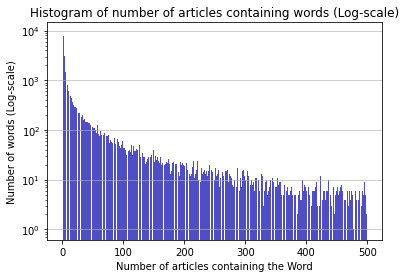

time: 2.18 s (started: 2021-10-12 03:19:22 +00:00)


In [ ]:
import matplotlib.pyplot as plt

# An "interface" to matplotlib.axes.Axes.hist() method
n, bins, patches = plt.hist(x=contain_mat_colsum, bins=range(500), color='#0504aa',
                            alpha=0.7, rwidth=0.85, log = True)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Number of articles containing the Word')
plt.ylabel('Number of words (Log-scale)')
plt.title('Histogram of number of articles containing words (Log-scale)')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

In [ ]:
# Exclude words that are included less than 5 articles

combined_BOW_matrix_filtered = combined_BOW_matrix[:,(contain_mat_colsum >= 5)]
wordlist_filtered = np.asarray(wordlist)[np.where(contain_mat_colsum >= 5)]
print(combined_BOW_matrix_filtered.shape, wordlist_filtered.shape) 

# Originally 54463 words in BOW, 27078 words remain after excluding rare appearing words

(67208, 27078) (27078,)
time: 124 ms (started: 2021-10-12 03:39:43 +00:00)


In [ ]:
# Now divide BOW matrix into dataset specific BOW matrices

'''
import pickle

with open('Kaggle1_fake_processed.p', 'rb') as Kaggle1_fake: 
    Kaggle1_fake_processed = pickle.load(Kaggle1_fake)

with open('Kaggle1_true_processed.p', 'rb') as Kaggle1_true: 
    Kaggle1_true_processed = pickle.load(Kaggle1_true)

with open('Kaggle2_processed.p', 'rb') as Kaggle2: 
    Kaggle2_processed = pickle.load(Kaggle2)

with open('Kaggle3_processed.p', 'rb') as Kaggle3: 
    Kaggle3_processed = pickle.load(Kaggle3)

with open('LIAR_processed.p', 'rb') as liar: 
    LIAR_processed = pickle.load(liar)

import pandas as pd
combined_df = pd.concat([Kaggle1_fake_processed, Kaggle1_true_processed, Kaggle2_processed, Kaggle3_processed, LIAR_processed], ignore_index=True)

with open('combined_df.p', 'wb') as file:
    pickle.dump(combined_df, file)
'''

K1_fake_dim = Kaggle1_fake_processed.shape[0]
K1_true_dim = Kaggle1_true_processed.shape[0]
K2_dim = Kaggle2_processed.shape[0]
K3_dim = Kaggle3_processed.shape[0]
L_dim = LIAR_processed.shape[0]

print("K1_fake_dim, K1_true_dim, K2_dim, K3_dim, L_dim =", K1_fake_dim, K1_true_dim, K2_dim, K3_dim, L_dim, "\n")

index = np.cumsum([K1_fake_dim, K1_true_dim, K2_dim, K3_dim, L_dim])

K1_fake_BOW_mat = combined_BOW_matrix_filtered[:index[0],]
K1_true_BOW_mat = combined_BOW_matrix_filtered[index[0]:index[1],]
K2_BOW_mat = combined_BOW_matrix_filtered[index[1]:index[2],]
K3_BOW_mat = combined_BOW_matrix_filtered[index[2]:index[3],]
L_BOW_mat = combined_BOW_matrix_filtered[index[3]:index[4],]

print(K1_fake_BOW_mat.shape, K1_true_BOW_mat.shape, K2_BOW_mat.shape, K3_BOW_mat.shape, L_BOW_mat.shape)

K1_fake_dim, K1_true_dim, K2_dim, K3_dim, L_dim = 23481 21417 10240 4009 8061 

(23481, 27078) (21417, 27078) (10240, 27078) (4009, 27078) (8061, 27078)
time: 92.2 ms (started: 2021-10-12 03:45:53 +00:00)


In [ ]:
# Training-Testing split on Kaggle1 data

import numpy as np
from sklearn.model_selection import train_test_split
import random

random.seed(10)
X_train_fake, X_test_fake, y_train_fake, y_test_fake = train_test_split(K1_fake_BOW_mat, Kaggle1_fake_processed['label'], test_size=0.4)
X_train_true, X_test_true, y_train_true, y_test_true = train_test_split(K1_true_BOW_mat, Kaggle1_true_processed['label'], test_size=0.4)
X_train_true, X_test_true, y_train_true, y_test_true

(<12850x27078 sparse matrix of type '<class 'numpy.int64'>'
 	with 1953645 stored elements in Compressed Sparse Row format>,
 <8567x27078 sparse matrix of type '<class 'numpy.int64'>'
 	with 1286472 stored elements in Compressed Sparse Row format>,
 10644    1
 791      1
 20796    1
 13418    1
 18904    1
         ..
 4280     1
 8756     1
 5249     1
 19228    1
 6608     1
 Name: label, Length: 12850, dtype: int64,
 14645    1
 10599    1
 10396    1
 4472     1
 6179     1
         ..
 15045    1
 5690     1
 15662    1
 19378    1
 18689    1
 Name: label, Length: 8567, dtype: int64)

time: 54.2 ms (started: 2021-10-12 04:11:35 +00:00)


In [ ]:
# Training-Testing split on Kaggle1 data

import numpy as np
from sklearn.model_selection import train_test_split

X_train_fake, X_test_fake, y_train_fake, y_test_fake = train_test_split(K1_fake_BOW_mat, Kaggle1_fake_processed['label'], test_size=0.4, random_state=0)
X_train_true, X_test_true, y_train_true, y_test_true = train_test_split(K1_true_BOW_mat, Kaggle1_true_processed['label'], test_size=0.4, random_state=0)

time: 47.2 ms (started: 2021-10-12 04:12:53 +00:00)


In [ ]:
X_train   = scipy.sparse.vstack([X_train_fake, X_train_true])
X_test_K1 = scipy.sparse.vstack([X_test_fake,  X_test_true ])
y_train   = pd.concat((y_train_fake, y_train_true))
y_test_K1 = pd.concat((y_test_fake,  y_test_true ))

print(X_train.shape)
X_train, y_test_K1

(26938, 27078)


(<26938x27078 sparse matrix of type '<class 'numpy.int64'>'
 	with 4141533 stored elements in Compressed Sparse Row format>, 9997     0
 8035     0
 644      0
 5105     0
 21573    0
         ..
 57       1
 15195    1
 16933    1
 16663    1
 1501     1
 Name: label, Length: 17960, dtype: int64)

time: 46.1 ms (started: 2021-10-12 04:14:40 +00:00)


In [ ]:
# Save as pickle object
with open('train.p', 'wb') as file:
    pickle.dump(X_train, file)
    pickle.dump(y_train, file)
    pickle.dump(wordlist_filtered, file)

with open('test_Kaggle1.p', 'wb') as file:
    pickle.dump(X_test_K1, file)
    pickle.dump(y_test_K1, file)
    pickle.dump(wordlist_filtered, file)

with open('test_Kaggle2.p', 'wb') as file:
    pickle.dump(K2_BOW_mat, file)
    pickle.dump(Kaggle2_processed['label'], file)
    pickle.dump(wordlist_filtered, file)

with open('test_Kaggle3.p', 'wb') as file:
    pickle.dump(K3_BOW_mat, file)
    pickle.dump(Kaggle3_processed['label'], file)
    pickle.dump(wordlist_filtered, file)

with open('test_LIAR.p', 'wb') as file:
    pickle.dump(L_BOW_mat, file)
    pickle.dump(LIAR_processed['label'], file)
    pickle.dump(wordlist_filtered, file)

time: 456 ms (started: 2021-10-12 04:25:56 +00:00)


In [ ]:
# To load objects

with open('train.p', 'rb') as file:
    X_train = pickle.load(file)
    y_train = pickle.load(file)
    wordlist_filtered = pickle.load(file)

with open('test_Kaggle1.p', 'rb') as file:
    X_test_K1 = pickle.load(file)
    y_test_K1 = pickle.load(file)
    wordlist_filtered = pickle.load(file)

with open('test_Kaggle2.p', 'rb') as file:
    X_test_K2 = pickle.load(file)
    y_test_K2 = pickle.load(file)
    wordlist_filtered = pickle.load(file)

with open('test_Kaggle3.p', 'rb') as file:
    X_test_K3 = pickle.load(file)
    y_test_K3 = pickle.load(file)
    wordlist_filtered = pickle.load(file)

with open('test_LIAR.p', 'rb') as file:
    X_test_L = pickle.load(file)
    y_test_L = pickle.load(file)
    wordlist_filtered = pickle.load(file)


time: 172 ms (started: 2021-10-12 04:28:21 +00:00)


In [ ]:
K2_BOW_mat, Kaggle2_processed['label']

(<10240x27078 sparse matrix of type '<class 'numpy.int64'>'
 	with 101371 stored elements in Compressed Sparse Row format>, 0        0
 1        1
 2        1
 3        0
 4        1
         ..
 10235    1
 10236    1
 10237    1
 10238    0
 10239    0
 Name: label, Length: 10240, dtype: int64)

time: 10.5 ms (started: 2021-10-12 04:15:27 +00:00)


In [ ]:
X_test_K2, y_test_K2

(<10240x27078 sparse matrix of type '<class 'numpy.int64'>'
 	with 101371 stored elements in Compressed Sparse Row format>, 0        0
 1        1
 2        1
 3        0
 4        1
         ..
 10235    1
 10236    1
 10237    1
 10238    0
 10239    0
 Name: label, Length: 10240, dtype: int64)

time: 10.7 ms (started: 2021-10-12 04:28:43 +00:00)


In [ ]:
X_test_K2.toarray().shape

(10240, 27078)

time: 1.82 s (started: 2021-10-12 04:37:27 +00:00)


In [ ]:
wordlist_filtered

array(['aa', 'aaa', 'aaaaaa', ..., 'zurich', 'zwei', 'zypries'],
      dtype='<U130')

time: 5.77 ms (started: 2021-10-12 04:38:25 +00:00)


# SVM

In [ ]:
from sklearn import svm

#Create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets
clf.fit(X_train, y_train)
#Predict the response for test datasets
y_pred_K1 = clf.predict(X_test_K1)
y_pred_K2 = clf.predict(X_test_K2)
y_pred_K3 = clf.predict(X_test_K3)
y_pred_L  = clf.predict(X_test_L)

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy: how often is the classifier correct?
print("Accuracy on Kaggle1:",metrics.accuracy_score(y_test_K1, y_pred_K1))
print("Accuracy on Kaggle2:",metrics.accuracy_score(y_test_K2, y_pred_K2))
print("Accuracy on Kaggle3:",metrics.accuracy_score(y_test_K3, y_pred_K3))
print("Accuracy on LIAR:",metrics.accuracy_score(y_test_L, y_pred_L))

Accuracy: 0.9739420935412026
time: 5min 11s (started: 2021-10-12 04:42:40 +00:00)


In [ ]:
# Train on Kaggle2
from sklearn import svm

#Create a svm Classifier
clf2 = svm.SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets
clf2.fit(X_test_K2, y_test_K2)

#Predict the response for test datasets
y_pred_K1_2 = clf2.predict(X_test_K1)
y_pred_K2_2 = clf2.predict(X_test_K2)
y_pred_K3_2 = clf2.predict(X_test_K3)
y_pred_L_2  = clf2.predict(X_test_L)

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy: how often is the classifier correct?
print("Accuracy on Kaggle1 (trained on Kaggle2):",metrics.accuracy_score(y_test_K1, y_pred_K1_2))
print("Accuracy on Kaggle2 (trained on Kaggle2):",metrics.accuracy_score(y_test_K2, y_pred_K2_2))
print("Accuracy on Kaggle3 (trained on Kaggle2):",metrics.accuracy_score(y_test_K3, y_pred_K3_2))
print("Accuracy on LIAR (trained on Kaggle2):",metrics.accuracy_score(y_test_L, y_pred_L_2))

Accuracy on Kaggle1 (trained on Kaggle2): 0.6035077951002227
Accuracy on Kaggle2 (trained on Kaggle2): 0.86259765625
Accuracy on Kaggle3 (trained on Kaggle2): 0.5372910950361687
Accuracy on LIAR (trained on Kaggle2): 0.820493735268577
time: 1min 20s (started: 2021-10-12 05:03:04 +00:00)


In [ ]:
# Train on Kaggle3
from sklearn import svm

#Create a svm Classifier
clf3 = svm.SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets
clf3.fit(X_test_K3, y_test_K3)

#Predict the response for test datasets
y_pred_K1_3 = clf3.predict(X_test_K1)
y_pred_K2_3 = clf3.predict(X_test_K2)
y_pred_K3_3 = clf3.predict(X_test_K3)
y_pred_L_3  = clf3.predict(X_test_L)

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy: how often is the classifier correct?
print("Accuracy on Kaggle1 (trained on Kaggle3):",metrics.accuracy_score(y_test_K1, y_pred_K1_3))
print("Accuracy on Kaggle2 (trained on Kaggle3):",metrics.accuracy_score(y_test_K2, y_pred_K2_3))
print("Accuracy on Kaggle3 (trained on Kaggle3):",metrics.accuracy_score(y_test_K3, y_pred_K3_3))
print("Accuracy on LIAR (trained on Kaggle3):",metrics.accuracy_score(y_test_L, y_pred_L_3))

Accuracy on Kaggle1 (trained on Kaggle3): 0.6189866369710467
Accuracy on Kaggle2 (trained on Kaggle3): 0.44169921875
Accuracy on Kaggle3 (trained on Kaggle3): 0.999002244948865
Accuracy on LIAR (trained on Kaggle3): 0.4431212008435678
time: 20.5 s (started: 2021-10-12 05:06:31 +00:00)


In [ ]:
# Train on LIAR
from sklearn import svm

#Create a svm Classifier
clfL = svm.SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets
clfL.fit(X_test_L, y_test_L)

#Predict the response for test datasets
y_pred_K1_L = clfL.predict(X_test_K1)
y_pred_K2_L = clfL.predict(X_test_K2)
y_pred_K3_L = clfL.predict(X_test_K3)
y_pred_L_L  = clfL.predict(X_test_L)

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy: how often is the classifier correct?
print("Accuracy on Kaggle1 (trained on LIAR):",metrics.accuracy_score(y_test_K1, y_pred_K1_L))
print("Accuracy on Kaggle2 (trained on LIAR):",metrics.accuracy_score(y_test_K2, y_pred_K2_L))
print("Accuracy on Kaggle3 (trained on LIAR):",metrics.accuracy_score(y_test_K3, y_pred_K3_L))
print("Accuracy on LIAR (trained on LIAR):",metrics.accuracy_score(y_test_L, y_pred_L_L))

Accuracy on Kaggle1 (trained on LIAR): 0.5935412026726058
Accuracy on Kaggle2 (trained on LIAR): 0.76591796875
Accuracy on Kaggle3 (trained on LIAR): 0.5295584933898728
Accuracy on LIAR (trained on LIAR): 0.9003845676715048
time: 52.9 s (started: 2021-10-12 05:05:24 +00:00)


##Gaussian Kernel SVM

In [ ]:
from sklearn import svm
from sklearn import metrics

#### Train on Kaggle1 ####

#Create a svm Classifier
clf = svm.SVC(kernel='rbf', C = 1) # Gaussian Kernel

#Train the model using the training sets
clf.fit(X_train, y_train)

#Predict the response for test datasets
y_pred_K1 = clf.predict(X_test_K1)
y_pred_K2 = clf.predict(X_test_K2)
y_pred_K3 = clf.predict(X_test_K3)
y_pred_L  = clf.predict(X_test_L)

# Model Accuracy: how often is the classifier correct?
print("Accuracy on Kaggle1 (trained on Kaggle1):",metrics.accuracy_score(y_test_K1, y_pred_K1))
print("Accuracy on Kaggle2 (trained on Kaggle1):",metrics.accuracy_score(y_test_K2, y_pred_K2))
print("Accuracy on Kaggle3 (trained on Kaggle1):",metrics.accuracy_score(y_test_K3, y_pred_K3))
print("Accuracy on LIAR (trained on Kaggle1):",metrics.accuracy_score(y_test_L, y_pred_L))


#### Train on Kaggle2 ####

#Create a svm Classifier
clf2 = svm.SVC(kernel='rbf', C = 1) # Gaussian Kernel

#Train the model using the training sets
clf2.fit(X_test_K2, y_test_K2)

#Predict the response for test datasets
y_pred_K1_2 = clf2.predict(X_test_K1)
y_pred_K2_2 = clf2.predict(X_test_K2)
y_pred_K3_2 = clf2.predict(X_test_K3)
y_pred_L_2  = clf2.predict(X_test_L)

# Model Accuracy: how often is the classifier correct?
print("Accuracy on Kaggle1 (trained on Kaggle2):",metrics.accuracy_score(y_test_K1, y_pred_K1_2))
print("Accuracy on Kaggle2 (trained on Kaggle2):",metrics.accuracy_score(y_test_K2, y_pred_K2_2))
print("Accuracy on Kaggle3 (trained on Kaggle2):",metrics.accuracy_score(y_test_K3, y_pred_K3_2))
print("Accuracy on LIAR (trained on Kaggle2):",metrics.accuracy_score(y_test_L, y_pred_L_2))


#### Train on Kaggle3 ####

#Create a svm Classifier
clf3 = svm.SVC(kernel='rbf', C = 1) # Gaussian Kernel

#Train the model using the training sets
clf3.fit(X_test_K3, y_test_K3)

#Predict the response for test datasets
y_pred_K1_3 = clf3.predict(X_test_K1)
y_pred_K2_3 = clf3.predict(X_test_K2)
y_pred_K3_3 = clf3.predict(X_test_K3)
y_pred_L_3  = clf3.predict(X_test_L)

# Model Accuracy: how often is the classifier correct?
print("Accuracy on Kaggle1 (trained on Kaggle3):",metrics.accuracy_score(y_test_K1, y_pred_K1_3))
print("Accuracy on Kaggle2 (trained on Kaggle3):",metrics.accuracy_score(y_test_K2, y_pred_K2_3))
print("Accuracy on Kaggle3 (trained on Kaggle3):",metrics.accuracy_score(y_test_K3, y_pred_K3_3))
print("Accuracy on LIAR (trained on Kaggle3):",metrics.accuracy_score(y_test_L, y_pred_L_3))


#### Train on LIAR ####

#Create a svm Classifier
clfL = svm.SVC(kernel='rbf', C = 1) # Gaussian Kernel

#Train the model using the training sets
clfL.fit(X_test_L, y_test_L)

#Predict the response for test datasets
y_pred_K1_L = clfL.predict(X_test_K1)
y_pred_K2_L = clfL.predict(X_test_K2)
y_pred_K3_L = clfL.predict(X_test_K3)
y_pred_L_L  = clfL.predict(X_test_L)

# Model Accuracy: how often is the classifier correct?
print("Accuracy on Kaggle1 (trained on LIAR):",metrics.accuracy_score(y_test_K1, y_pred_K1_L))
print("Accuracy on Kaggle2 (trained on LIAR):",metrics.accuracy_score(y_test_K2, y_pred_K2_L))
print("Accuracy on Kaggle3 (trained on LIAR):",metrics.accuracy_score(y_test_K3, y_pred_K3_L))
print("Accuracy on LIAR (trained on LIAR):",metrics.accuracy_score(y_test_L, y_pred_L_L))

Accuracy on Kaggle1 (trained on Kaggle1): 0.9751113585746103
Accuracy on Kaggle2 (trained on Kaggle1): 0.43837890625
Accuracy on Kaggle3 (trained on Kaggle1): 0.7173858817660265
Accuracy on LIAR (trained on Kaggle1): 0.44113633544225284
Accuracy on Kaggle1 (trained on Kaggle2): 0.5043986636971047
Accuracy on Kaggle2 (trained on Kaggle2): 0.900390625
Accuracy on Kaggle3 (trained on Kaggle2): 0.5173359940134697
Accuracy on LIAR (trained on Kaggle2): 0.8578340156308151
Accuracy on Kaggle1 (trained on Kaggle3): 0.6287861915367483
Accuracy on Kaggle2 (trained on Kaggle3): 0.52685546875
Accuracy on Kaggle3 (trained on Kaggle3): 0.9920179595909204
Accuracy on LIAR (trained on Kaggle3): 0.5315717652896663
Accuracy on Kaggle1 (trained on LIAR): 0.5053452115812918
Accuracy on Kaggle2 (trained on LIAR): 0.78203125
Accuracy on Kaggle3 (trained on LIAR): 0.47418308805188325
Accuracy on LIAR (trained on LIAR): 0.9130380846048878
time: 20min 53s (started: 2021-10-12 05:16:25 +00:00)
